# Getting Started: Pixel-Level Segmentation (Task 2)

### Install the required packages

In [1]:
#Download and install Pytorch for CUDA 10.2
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu102
#Download and install Pytorch for CUDA 11.3
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
    
!pip install intern
!pip install scikit-learn
!pip install timm
!pip install pretrainedmodels
!pip install efficientnet_pytorch

#setting up the segmentation_models.pytorch library
!pip install github-clone
!ghclone https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch 
!cp -rf segmentation_models_pytorch ../MTNeuro/.
!rm -rf segmentation_models_pytorch


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu102
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


Cloning into 'segmentation_models_pytorch'...
done.


### Importing required packages


In [2]:
#import libraries and set random seed
import sys
import matplotlib.pyplot as plt
import numpy as np
import json as json
from tqdm import tqdm

#pytorch imports
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

sys.path.append('../MTNeuro/')                 #setting the location to look for the required packages
#BossDB library and MTNeuro dataset loader
from intern import array
from bossdbdataset import BossDBDataset               

from trainer import Trainer                    #trainer function used to train the models
from models.unet import UNet                          #UNet model. From: https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial
import segmentation_models_pytorch as smp      #SMP library (used for calculation of performance metrics: https://github.com/qubvel/segmentation_models.pytorch

from sklearn.metrics import ConfusionMatrixDisplay

torch.manual_seed(0)
np.random.seed(0)

## Loading the Configurations for training a Pytorch Model


U-Net model from https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial
is used as an example model for demonstrating data access and training

### For training a 2D Model in 4-Class Setting

In [3]:
##load the task config for 2D 4-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_2D_4class.json'))

##Load the network config for the 2D model for 4-class setting, with the batch size and model config information
network_config = json.load(open('../MTNeuro/networkconfig/UNet_2D_4class.json'))

### For training a 2D model in 3-Class Setting 

In [24]:
##load the task config for 2D 3-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_2D_3class.json'))

##Load the network config for the 2D model for 3-class setting, with the batch size and model config information
network_config = json.load(open('../MTNeuro/networkconfig/UNet_2D_3class.json'))

### For training a 3D model in 4-Class Setting 

In [64]:
##load the task config for 3D 4-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_3D_4class.json'))

##Load the network config for the 3D model for 4-class setting, with the batch size and model config information
network_config = json.load(open('../MTNeuro/networkconfig/UNet_3D_4class.json'))

### For training a 3D model in 3-Class Setting 

In [55]:
##load the task config for 3D 3-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_3D_3class.json'))

##Load the network config for the 3D model for 3-class setting, with the batch size and model config information
network_config = json.load(open('../MTNeuro/networkconfig/UNet_3D_3class.json'))

## Load the Data using the BossDB dataloader

In [4]:
####Specify the required transforms and load the data for task 2

##if no transformations are preferred for the data
transform = transforms.Compose([transforms.ToTensor(),])

##Set-up the train dataloader and validation dataloader
train_data =  BossDBDataset(task_config, None, 'train', image_transform = transform, mask_transform = transform)
val_data = BossDBDataset(task_config, None, 'val', image_transform = transform, mask_transform = transform)

train_dataloader = DataLoader(dataset=train_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)
validation_dataloader = DataLoader(dataset=val_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)

In [5]:
#access the input and the groundtruth of first batch
x,y = next(iter(train_dataloader))

#shape of the batch
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; classes: {y.unique()}; type: {y.dtype}')
print(f'y = min: {y.min()}; max: {y.max()}')

x = shape: torch.Size([8, 1, 256, 256]); type: torch.float32
x = min: 0.0; max: 0.9490196108818054
y = shape: torch.Size([8, 256, 256]); classes: tensor([0, 1, 2]); type: torch.int64
y = min: 0; max: 2


## Visualize the data

### Visualize the a slice from the first batch and its groundtruth annotation


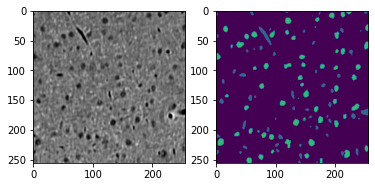

In [6]:
plt.subplot(1,2,1)
plt.imshow(x.squeeze()[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y.squeeze()[0], vmin=0, vmax=3)

### Create a collage of random slices from the training data

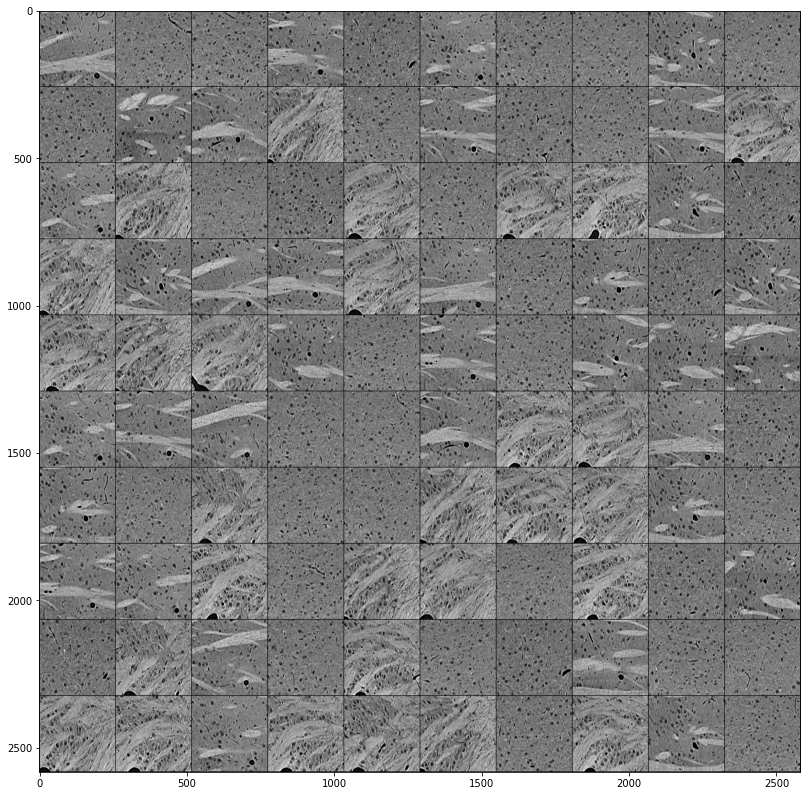

In [7]:
import random

#reshape data and select a random subset of 100 slices
if network_config['dim']==3:
    reshaped_data = []
    for data in train_data:
        reshaped_data = reshaped_data + list(data[0][0])

#    
##    reshaped_data = torch.reshape(torch.stack([data[0][0] for data in train_data]), shape=(-1, 256, 256))
 ##   perm = torch.randperm(reshaped_data.size(0))
 #   idx = perm[:100]
 #   reshaped_data = reshaped_data[idx]
if network_config['dim']==2:
    #reshaped_data = torch.reshape(torch.stack(random.sample([data[0][0] for data in train_data], 100)), shape=(-1,256, 256))
    reshaped_data = [data[0][0] for data in train_data]
random_samples_from_data = random.sample(reshaped_data,100)
    
grid_img = make_grid(torch.stack(random_samples_from_data).unsqueeze(1), nrow=10)
plt.figure(figsize=(14,14))
plt.imshow(grid_img[0], cmap='gray')

## Load the model 

In [8]:
## Specify the device to run the model on
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Load the model with the configuration specifiedd through UNet_2D.json
print('loading UNet model')
model = UNet(in_channels=network_config['in_channels'],
            out_channels=network_config['classes'],
            n_blocks=network_config['n_blocks'],
            start_filters=network_config['start_filters'],
            activation=network_config['activation'],
            normalization=network_config['normalization'],
            conv_mode=network_config['conv_mode'],
            dim=network_config['dim']).to(device)
print('Done loading the model')

loading UNet model
Done loading the model


## Set the Loss criteria and the Optimizer

In [9]:
# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer (picks the required information from the network config file UNet_2D.json)
if network_config["optimizer"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=network_config["learning_rate"])
if network_config["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=network_config["learning_rate"], betas=(network_config["beta1"],network_config["beta2"]))
 

## Train the model

In [10]:
###Configure the trainer
trainer = Trainer(model=model,
                    device=device,
                    criterion=criterion,
                    optimizer=optimizer,
                    training_DataLoader=train_dataloader,
                    validation_DataLoader=validation_dataloader,
                    lr_scheduler=None,
                    epochs=network_config["epochs"],
                    notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

### Evaluate the model

In [11]:
#function to predict using trained model
def predict(img, model, device):
        model.eval()
        x = img.to(device)            #send input to device
        with torch.no_grad():
            out = model(x)            #model forward pass

        out_argmax = torch.argmax(out, dim=1)  #perform softmax on outputs
        return out_argmax

In [12]:
#take and save the predictions and corresponding metrics
#load the test data
test_data =  BossDBDataset(task_config, None, "test", image_transform = transform, mask_transform = transform)
test_dataloader = DataLoader(dataset=test_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)
 
batch_iter = tqdm(enumerate(test_dataloader), 'test', total=len(test_dataloader), leave=False)
#variables for storing the True Postive, False Positive, False Negative and True Negative scores respectively
tp_tot = torch.empty(0,network_config['classes'])
fp_tot = torch.empty(0,network_config['classes'])
fn_tot = torch.empty(0,network_config['classes'])
tn_tot = torch.empty(0,network_config['classes'])

for i, (x, y) in batch_iter:
    target = y.to(device) #can do this on CPU
    with torch.no_grad():
        #pass the input image through the model and get the output image
        output = predict(x, model, device)
        #calculate the true positive, false positive and false negative
        tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes = network_config['classes'])
        tp_tot = torch.vstack((tp_tot,tp))
        fp_tot = torch.vstack((fp_tot,fp))
        fn_tot = torch.vstack((fn_tot,fn))
        tn_tot = torch.vstack((tn_tot,tn))

### Calculate Performance Metrics

In [13]:
# Accuracy: (tp + fp) / (fp + tn + fn + tp)
acc = (tp_tot.mean(dim=0)+tn_tot.mean(dim=0))/(fp_tot.mean(dim=0)+tn_tot.mean(dim=0)+fn_tot.mean(dim=0)+tp_tot.mean(dim=0)) 
print('new Accuracy per Class:')
print(np.array(acc.cpu()))

# Balanced Accuracy:  (Specificity + Sensitivity / 2)
spec =  (tn_tot[:,1:].mean())/(fp_tot[:,1:].mean()+tn_tot[:,1:].mean())
sens =  (tp_tot[:,1:].mean())/(fn_tot[:,1:].mean()+tp_tot[:,1:].mean())
balacc = (spec + sens)/2
print(f'new Balanced accuracy (No background): {balacc}')

# F1-score: 2* precision * recall / (precision + recall)
prec = tp_tot.mean(dim=0)/(fp_tot.mean(dim=0)+tp_tot.mean(dim=0))
reca = tp_tot.mean(dim=0)/(fn_tot.mean(dim=0)+tp_tot.mean(dim=0))
f1 = (2*reca*prec)/(reca+prec)
print(f'new F1-score: {np.array(f1.cpu())} Avg. F1-score: {f1.mean()}')

# IoU: tp /(fp + fn + tp)
iou = (tp_tot.mean(0))/(fp_tot.mean(0)+fn_tot.mean(0)+tp_tot.mean(0))
print(f'new IoU: {np.array(iou.cpu())} Avg. IoU-score: {iou.mean()}')

new Accuracy per Class:
[0.80117154 0.97634554 0.970852   0.8272174 ]
new Balanced accuracy (No background): 0.8867765069007874
new F1-score: [0.8307525  0.55929196 0.71131676 0.742338  ] Avg. F1-score: 0.7109248042106628
new IoU: [0.7105018  0.3882063  0.55197173 0.59025234] Avg. IoU-score: 0.5602330565452576
